# Twitter Sentiment Analysis

### About Data

## Collecting/Getting Data

#### Dependencies

In [3]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import ngrams
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords 
import string
from collections import Counter
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier




plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# Read Data from csv file
tweets_data = pd.read_csv("train.csv",encoding='ISO-8859-1')

## Explore and Clean Data

### 1 Explore and understand data 

In [5]:
tweets_data

ItemID  sentiment                                               text
0           1          0           is so sad for my APL friend.............
1           2          0                   I missed the New Moon trailer...
2           3          1                            omg its already 7:30 :O
3           4          0  Omgaga. Im sooo  im gunna CRy. I've been at th...
4           5          0       i think mi bf is cheating on me!!!       T_T
...       ...        ...                                                ...
99983   99996          0  @Cupcake  seems like a repeating problem   hop...
99984   99997          1  @cupcake__ arrrr we both replied to each other...
99985   99998          0                      @CuPcAkE_2120 ya i thought so
99986   99999          1  @Cupcake_Dollie Yes. Yes. I'm glad you had mor...
99987  100000          1                     @cupcake_kayla haha yes you do

[99988 rows x 3 columns]

In [6]:
tweets_data.columns

Index(['ItemID', 'sentiment', 'text'], dtype='object')

We don't need 'ItemID' column

In [7]:
tweets_data =tweets_data.drop(['ItemID'], axis=1)
tweets_data

sentiment                                               text
0              0           is so sad for my APL friend.............
1              0                   I missed the New Moon trailer...
2              1                            omg its already 7:30 :O
3              0  Omgaga. Im sooo  im gunna CRy. I've been at th...
4              0       i think mi bf is cheating on me!!!       T_T
...          ...                                                ...
99983          0  @Cupcake  seems like a repeating problem   hop...
99984          1  @cupcake__ arrrr we both replied to each other...
99985          0                      @CuPcAkE_2120 ya i thought so
99986          1  @Cupcake_Dollie Yes. Yes. I'm glad you had mor...
99987          1                     @cupcake_kayla haha yes you do

[99988 rows x 2 columns]

In [8]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99988 entries, 0 to 99987
Data columns (total 2 columns):
sentiment    99988 non-null int64
text         99988 non-null object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [9]:
#for counting ham and spam

tweets_data.sentiment.value_counts()

1    56456
0    43532
Name: sentiment, dtype: int64

In [10]:
tweets_data.groupby('sentiment').describe()

text                                                          
           count unique                                           top freq
sentiment                                                                 
0          43532  43532       @CJLeBlanc you guys never come to Utah!    1
1          56456  56456  @alphaharlot Hey - love your videos on xtube    1

### 2 Clean Data

In [11]:
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [12]:
lenn = len(tweets_data)
lenn
tweets_data.text

0                 is so sad for my APL friend.............
1                         I missed the New Moon trailer...
2                                  omg its already 7:30 :O
3        Omgaga. Im sooo  im gunna CRy. I've been at th...
4             i think mi bf is cheating on me!!!       T_T
                               ...                        
99983    @Cupcake  seems like a repeating problem   hop...
99984    @cupcake__ arrrr we both replied to each other...
99985                        @CuPcAkE_2120 ya i thought so
99986    @Cupcake_Dollie Yes. Yes. I'm glad you had mor...
99987                       @cupcake_kayla haha yes you do
Name: text, Length: 99988, dtype: object

In [13]:
tweets_data[tweets_data.isnull().any(axis=1)].head()

Empty DataFrame
Columns: [sentiment, text]
Index: []

We don't have NaN data for now

In [14]:
%%time
print ("Cleaning the tweets...\n")
clean_tweet_texts = []
for row in tweets_data.text:
    clean_tweet_texts.append(tweet_cleaner_updated(row))

Cleaning the tweets...

CPU times: user 28.9 s, sys: 1.73 s, total: 30.7 s
Wall time: 31.7 s


In [15]:
clean_tweet_texts

['is so sad for my apl friend',
 'missed the new moon trailer',
 'omg its already',
 'omgaga im sooo im gunna cry ve been at this dentist since was suposed just get crown put on mins',
 'think mi bf is cheating on me',
 'or just worry too much',
 'sunny again work tomorrow tv tonight',
 'handed in my uniform today miss you already',
 'hmmmm wonder how she my number',
 'must think about positive',
 'thanks to all the haters up in my face all day',
 'this weekend has sucked so far',
 'jb isnt showing in australia any more',
 'ok thats it you win',
 'this is the way feel right now',
 'awhhe man completely useless rt now funny all can do is twitter',
 'feeling strangely fine now gonna go listen to some semisonic to celebrate',
 'huge roll of thunder just now so scary',
 'just cut my beard off it only been growing for well over year gonna start it over is happy in the meantime',
 'very sad about iran',
 'wompppp wompp',
 'you re the only one who can see this cause no one else is following m

In [16]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['sentiment'] = tweets_data.sentiment
clean_df.to_csv('clean_tweets.csv',encoding='utf-8')

In [17]:
csv = 'clean_tweets.csv'
clean_tweets_data = pd.read_csv(csv,index_col=0)
clean_tweets_data

text  sentiment
0                            is so sad for my apl friend          0
1                            missed the new moon trailer          0
2                                        omg its already          1
3      omgaga im sooo im gunna cry ve been at this de...          0
4                          think mi bf is cheating on me          0
...                                                  ...        ...
99983  seems like repeating problem hope you re able ...          0
99984  arrrr we both replied to each other over diffe...          1
99985                                      ya thought so          0
99986              yes yes glad you had more fun with me          1
99987                                    haha yes you do          1

[99988 rows x 2 columns]

In [18]:
clean_tweets_data[clean_tweets_data.isnull().any(axis=1)]

text  sentiment
225    NaN          1
228    NaN          1
233    NaN          0
252    NaN          0
694    NaN          1
...    ...        ...
99361  NaN          0
99441  NaN          1
99583  NaN          0
99651  NaN          1
99971  NaN          1

[465 rows x 2 columns]

We have NaN data, we have to clean our data

In [19]:
np.sum(clean_tweets_data.isnull().any(axis=1))

465

In [20]:
clean_tweets_data.isnull().any(axis=0)

text          True
sentiment    False
dtype: bool

In [21]:
clean_tweets_data.dropna(inplace=True)
clean_tweets_data.reset_index(drop=True,inplace=True)
clean_tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99523 entries, 0 to 99522
Data columns (total 2 columns):
text         99523 non-null object
sentiment    99523 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


## Data Visualition

Text(0.5,1,'Distribution of Positive and Negative')

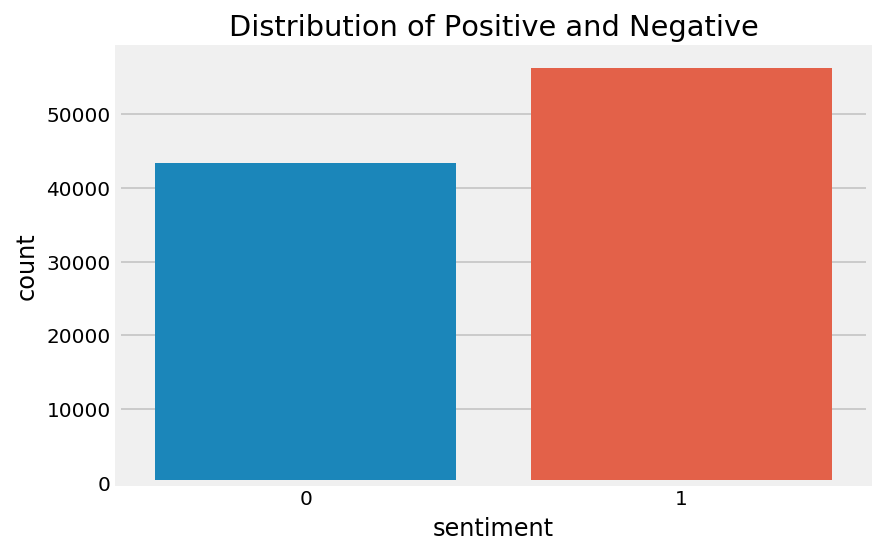

In [20]:
#plotting graph for distribution

sns.countplot(x = "sentiment", data = clean_tweets_data)
clean_tweets_data.loc[:,'sentiment'].value_counts()
plt.title('Distribution of Positive and Negative')

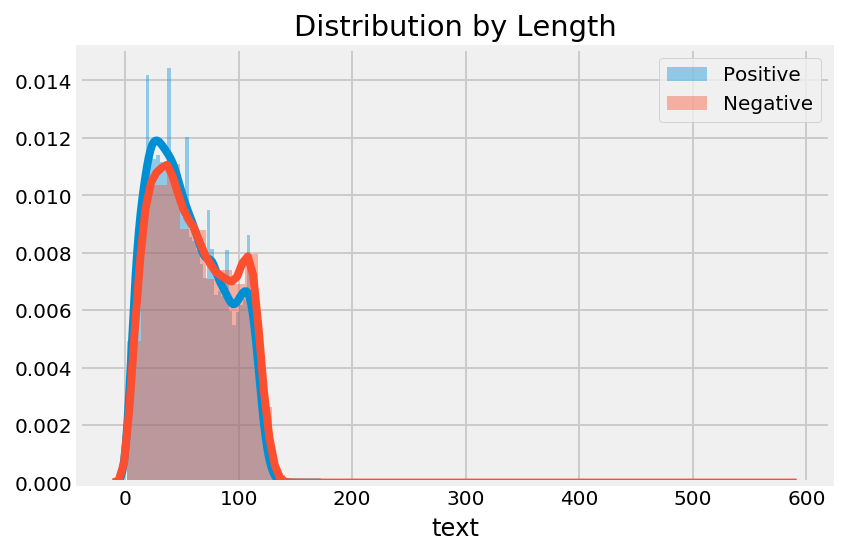

In [22]:
# plotting graph by length.

pos =clean_tweets_data[clean_tweets_data['sentiment'] == 1]['text'].str.len()
sns.distplot(pos, label='Positive')
neg = clean_tweets_data[clean_tweets_data['sentiment'] == 0]['text'].str.len()
sns.distplot(neg, label='Negative')
plt.title('Distribution by Length')
plt.legend()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


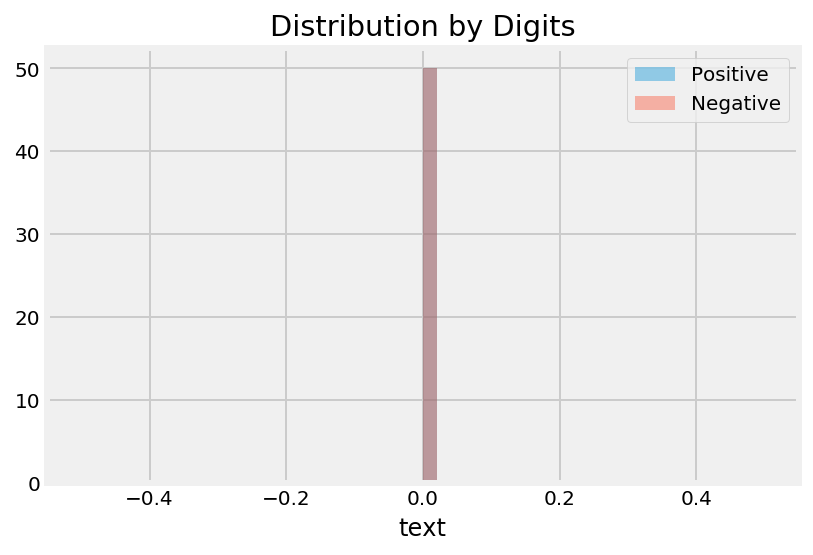

In [23]:
#plotting graph by digits.

pos1 = clean_tweets_data[clean_tweets_data['sentiment'] == 1 ]['text'].str.replace(r'\D+', '').str.len()
sns.distplot(pos1, label='Positive')
neg1 = clean_tweets_data[clean_tweets_data['sentiment'] == 0 ]['text'].str.replace(r'\D+', '').str.len()
sns.distplot(neg1, label='Negative')
plt.title('Distribution by Digits')
plt.legend()

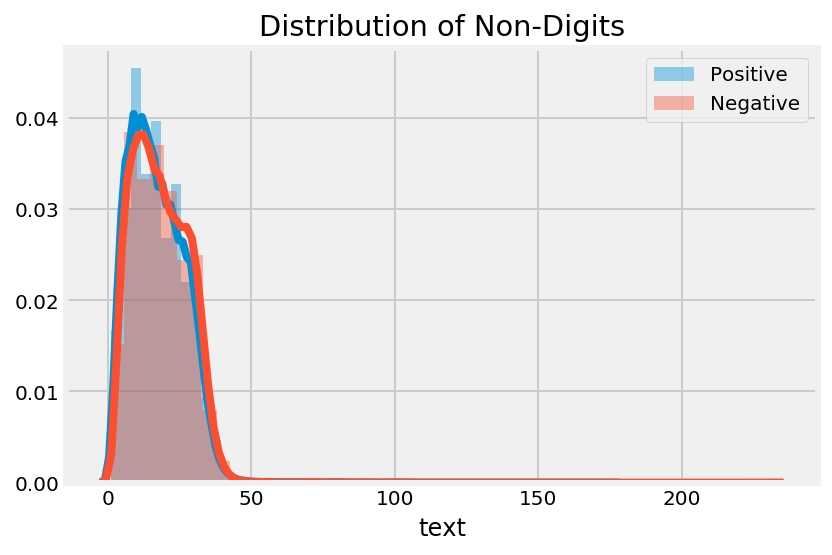

In [24]:
#plotting graph for non-digits.

pos2 = tweets_data[tweets_data['sentiment'] == 1]['text'].str.replace(r'\w+', '').str.len()
sns.distplot(pos2, label='Positive')
neg2 = tweets_data[tweets_data['sentiment'] == 0]['text'].str.replace(r'\w+', '').str.len()
sns.distplot(neg2, label='Negative')
plt.title('Distribution of Non-Digits')
plt.legend()

In [25]:
from collections import Counter
#for counting frequently occurence of pos and neg.

count1 = Counter(" ".join(clean_tweets_data[clean_tweets_data['sentiment']== 1]["text"]).split()).most_common(30)
data1 = pd.DataFrame.from_dict(count1)
data1 = data1.rename(columns={0: "words of pos", 1 : "count"})
count2 = Counter(" ".join(clean_tweets_data[clean_tweets_data['sentiment']== 0]["text"]).split()).most_common(30)
data2 = pd.DataFrame.from_dict(count2)
data2 = data2.rename(columns={0: "words of neg", 1 : "count_"})

#### Graph for top 30 words of positive

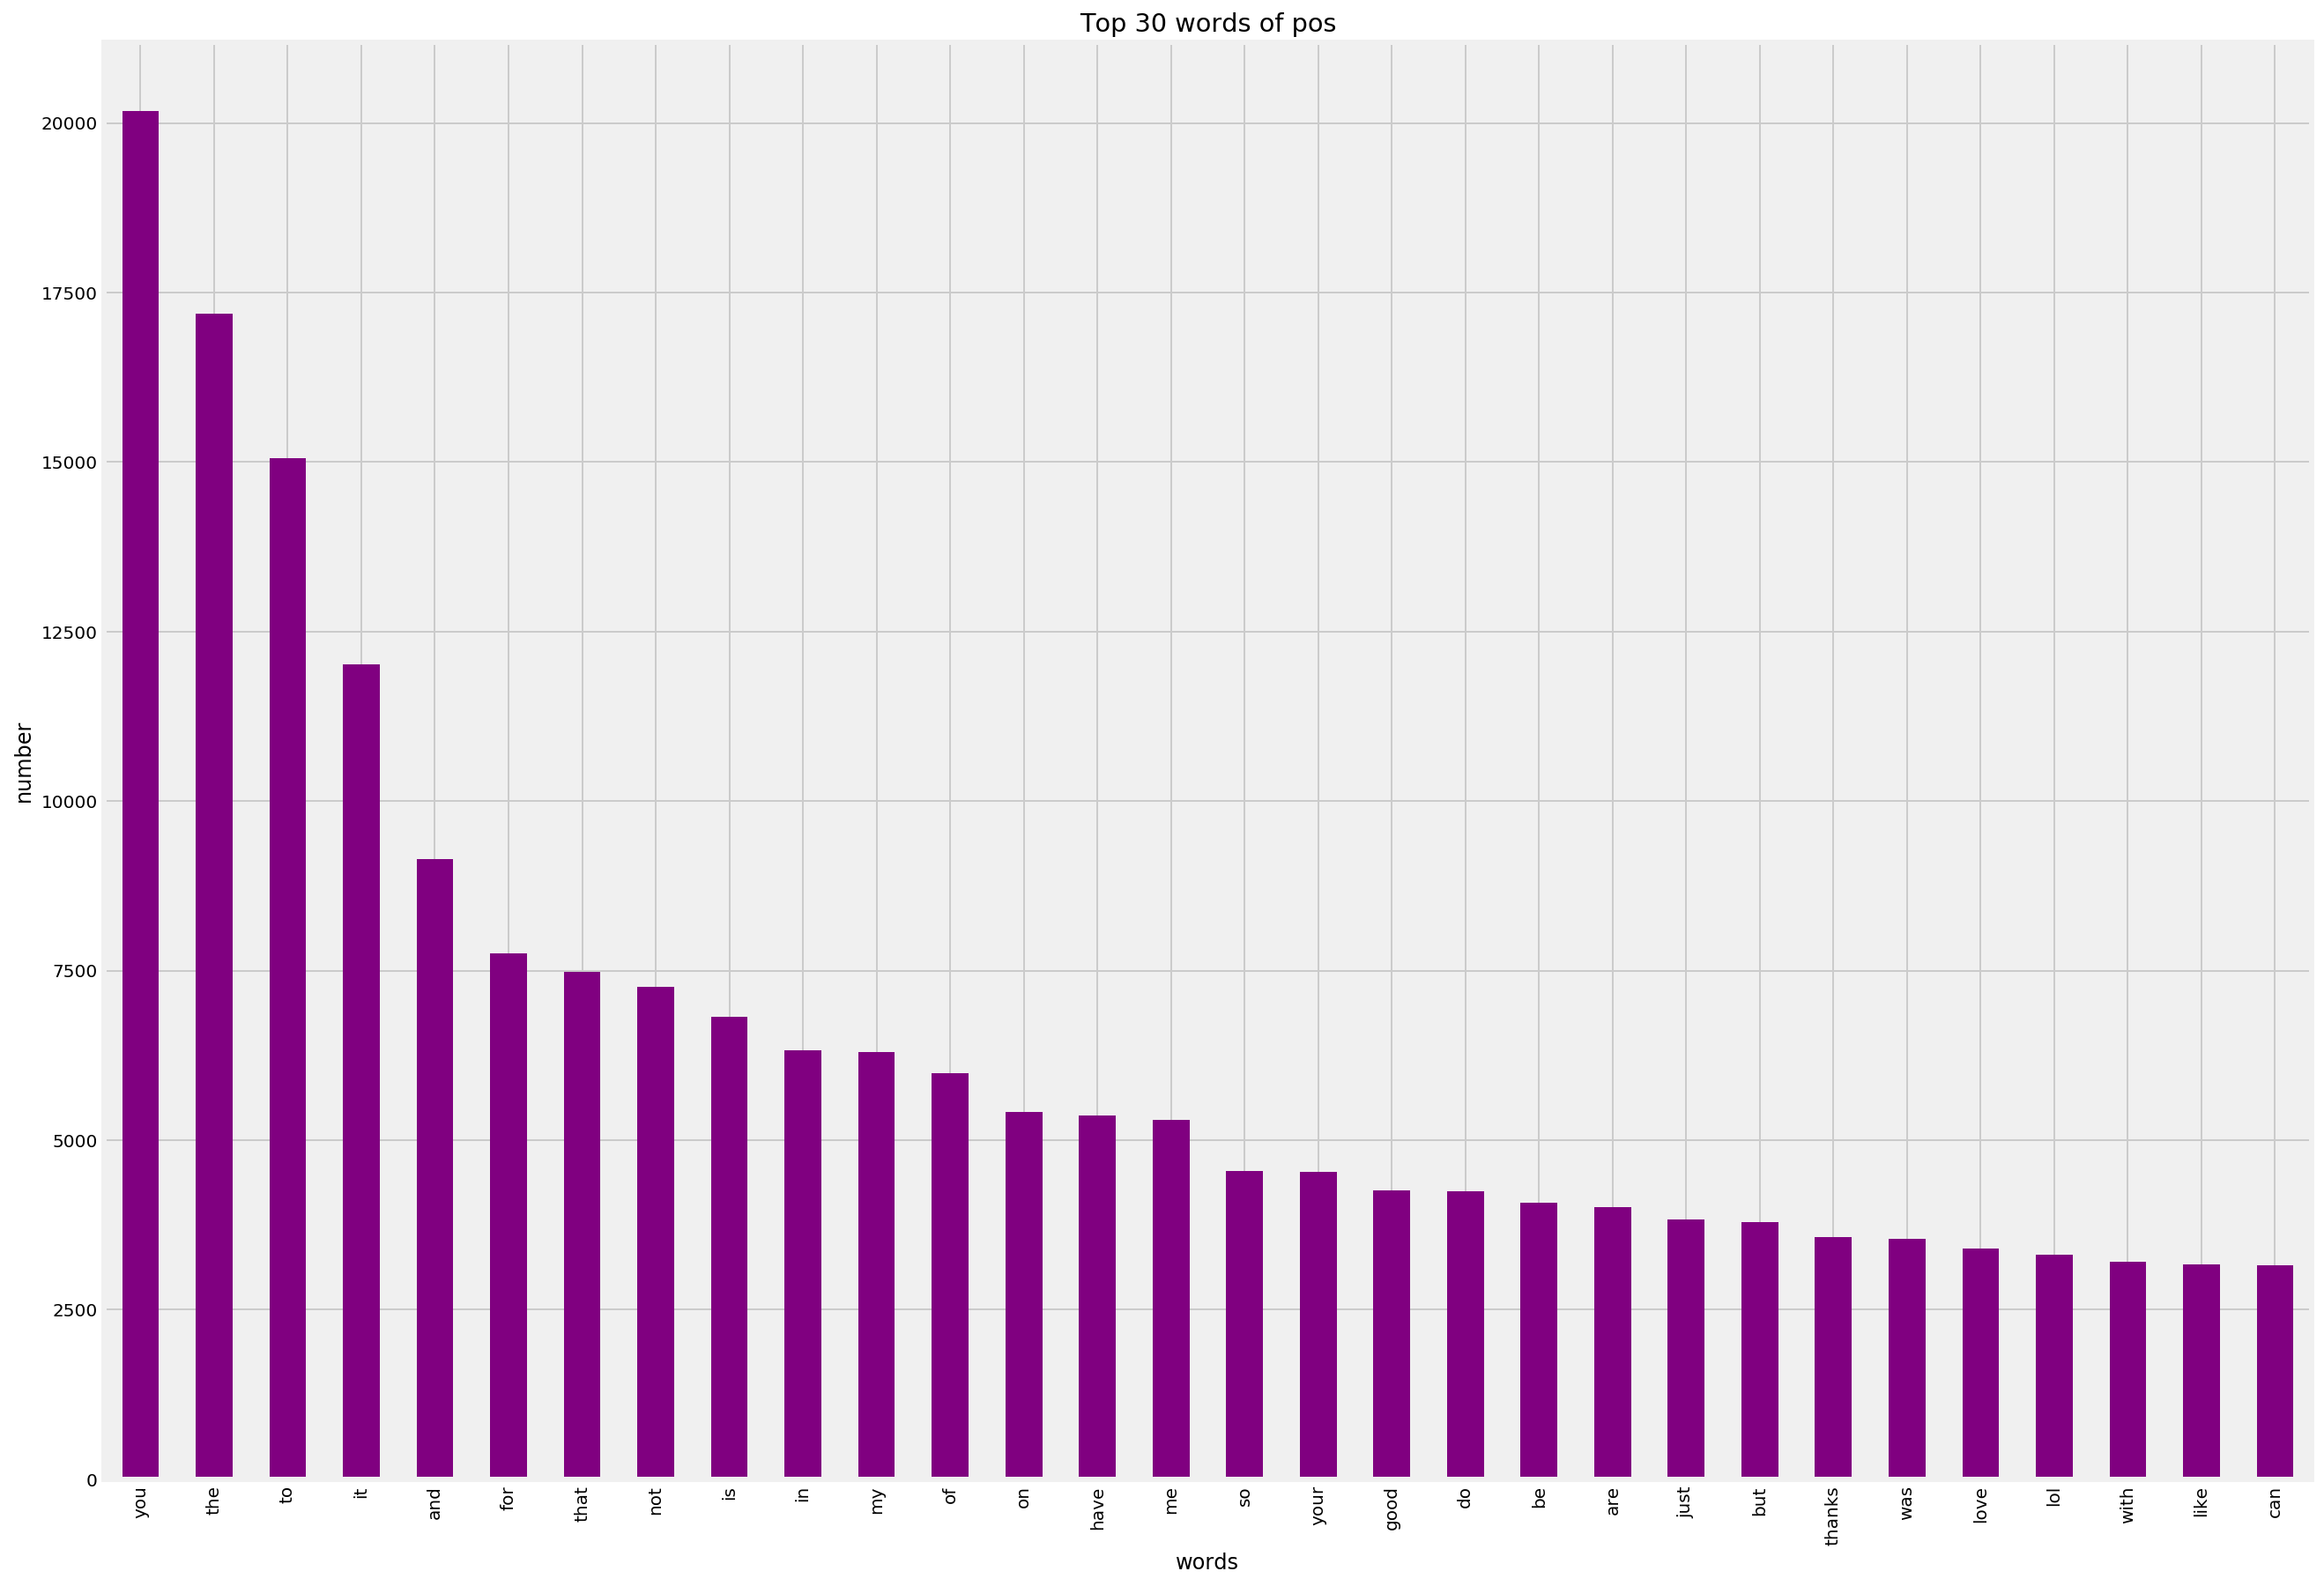

In [26]:
data1.plot.bar(legend = False, color = 'purple',figsize = (20,15))
y_pos = np.arange(len(data1["words of pos"]))
plt.xticks(y_pos, data1["words of pos"])
plt.title('Top 30 words of pos')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

#### Graph for top 30 words of negative

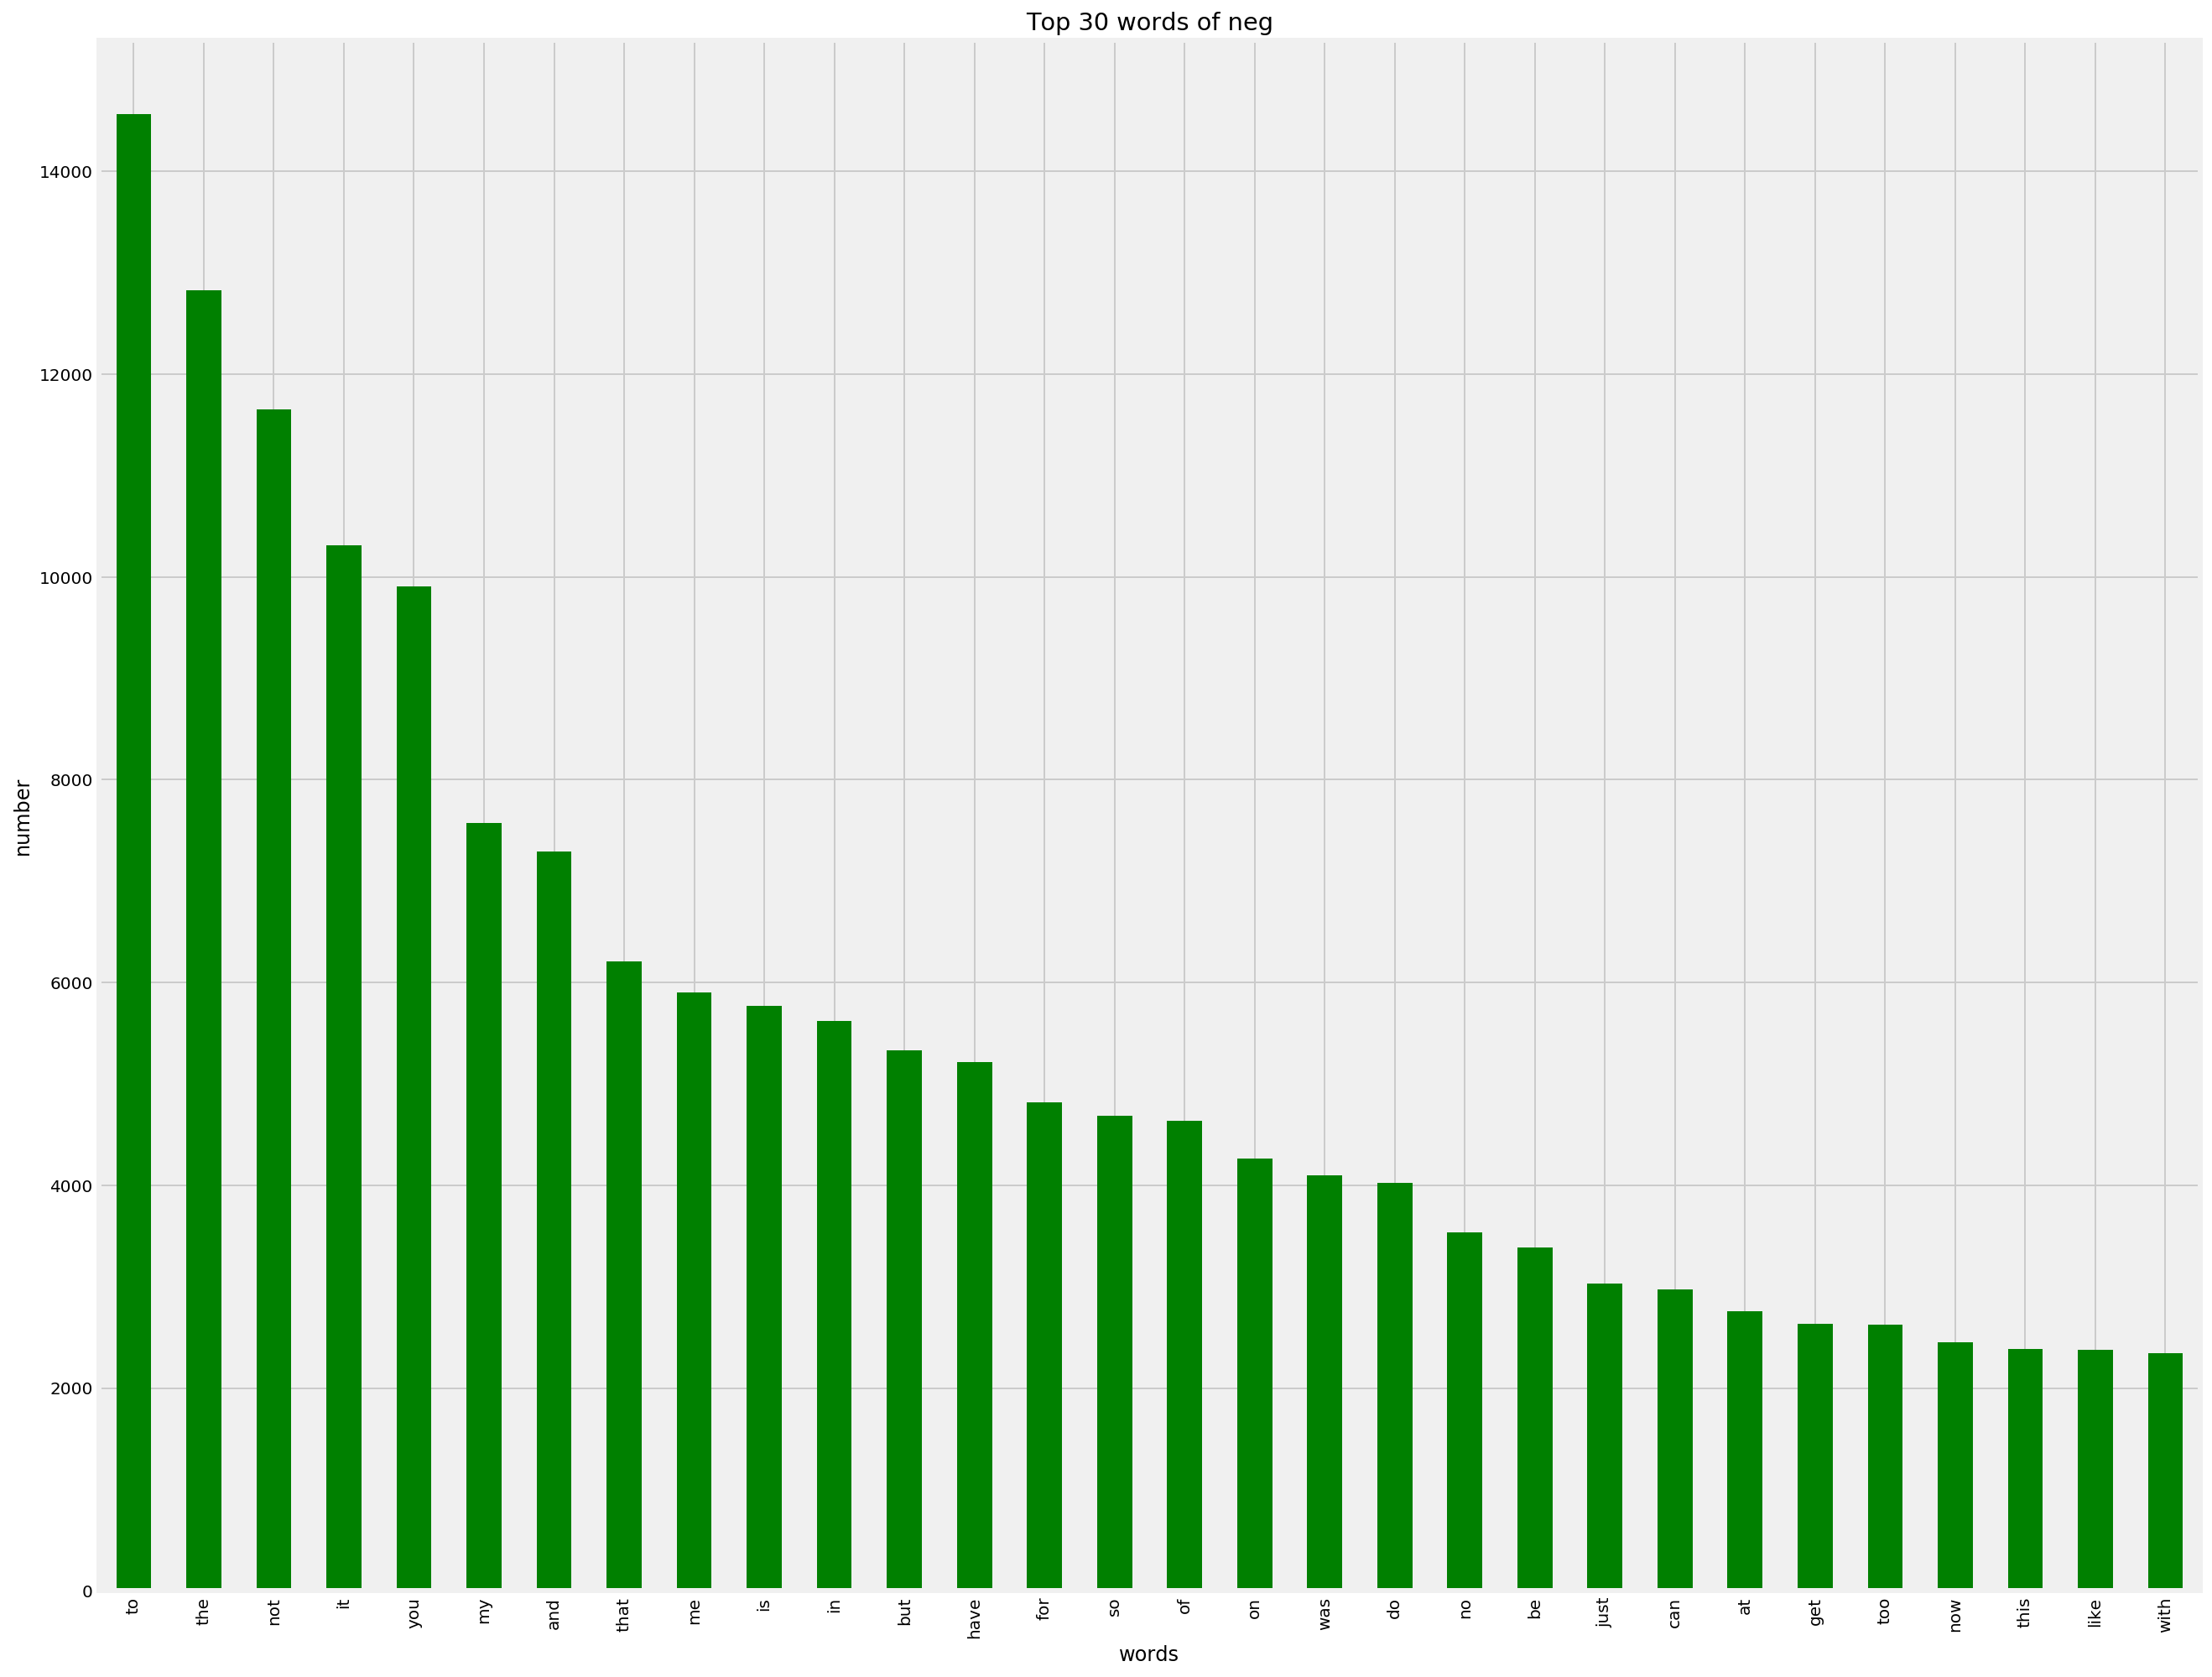

In [27]:
data2.plot.bar(legend = False, color = 'green', figsize = (20,17))
y_pos = np.arange(len(data2["words of neg"]))
plt.xticks(y_pos, data2["words of neg"])
plt.title('Top 30 words of neg')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

### Word Cloud
#### 1 word Cloud for negative strings

In [28]:
neg_tweets = clean_tweets_data[clean_tweets_data.sentiment == 0]
# neg_tweets

neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
# neg_string
neg_string = pd.Series(neg_string).str.cat(sep=' ')
# neg_string

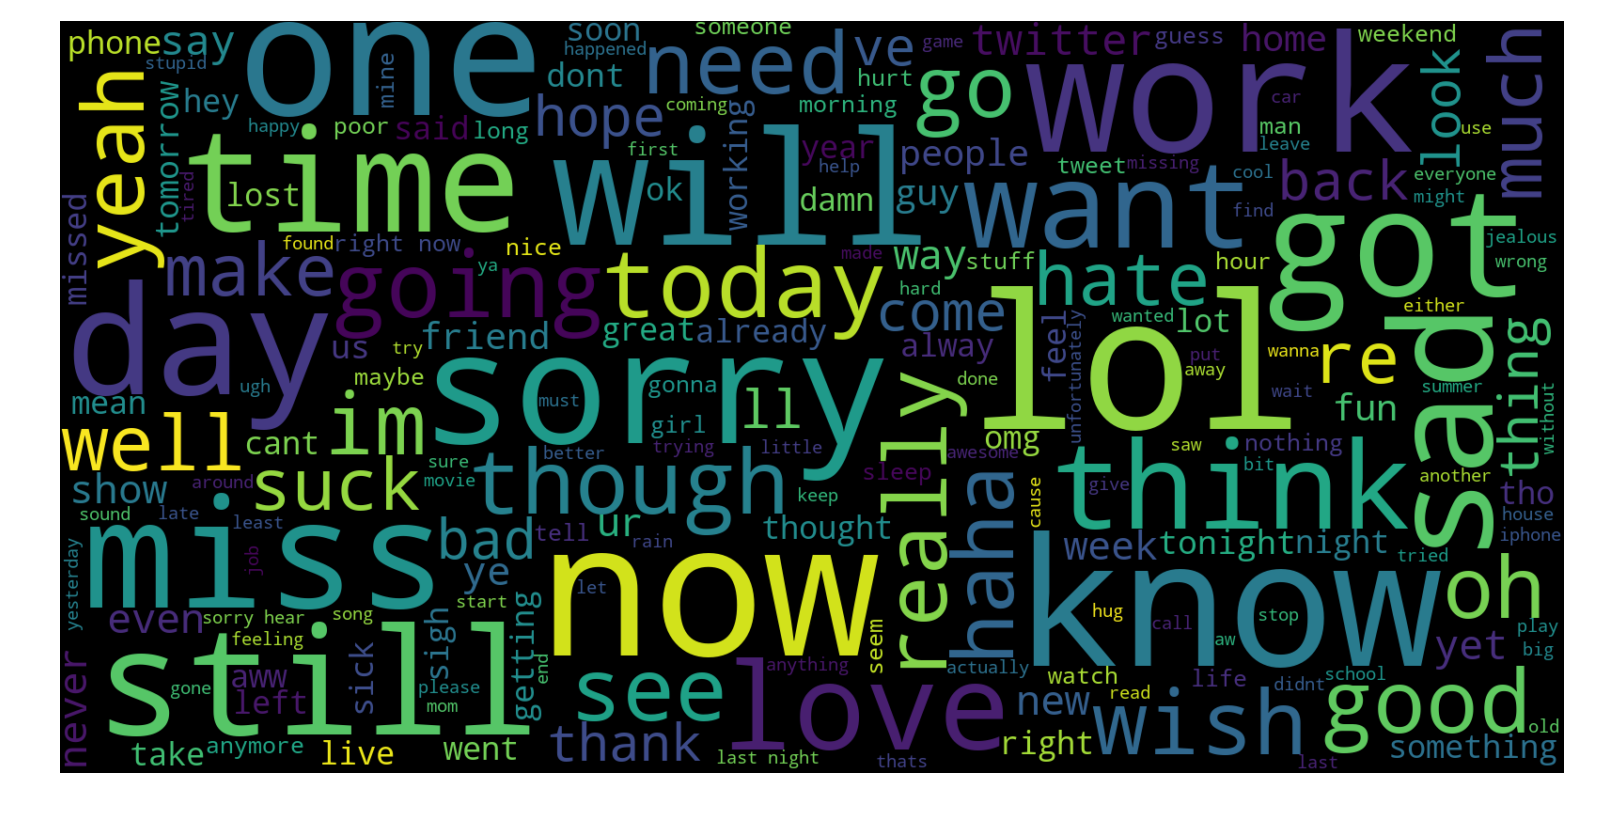

In [29]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [30]:
for t in neg_tweets.text[:200]:
    if 'love' in t:
        print (t)

friends are leaving me cause of this stupid love
love you guys so much that it hurts
jus got hom fr tda funeral so sad cried so much times much love grandpa never got to say my last goodbye to him
miss my love jamie


OK, even though the tweets contain the word "love", in these cases it is negative sentiment because the tweet has mixed emotions like "love" but "miss". Or sometimes used in a sarcastic way.

#### 2 word Cloud for positive strings

In [31]:
pos_tweets = clean_tweets_data[clean_tweets_data.sentiment == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

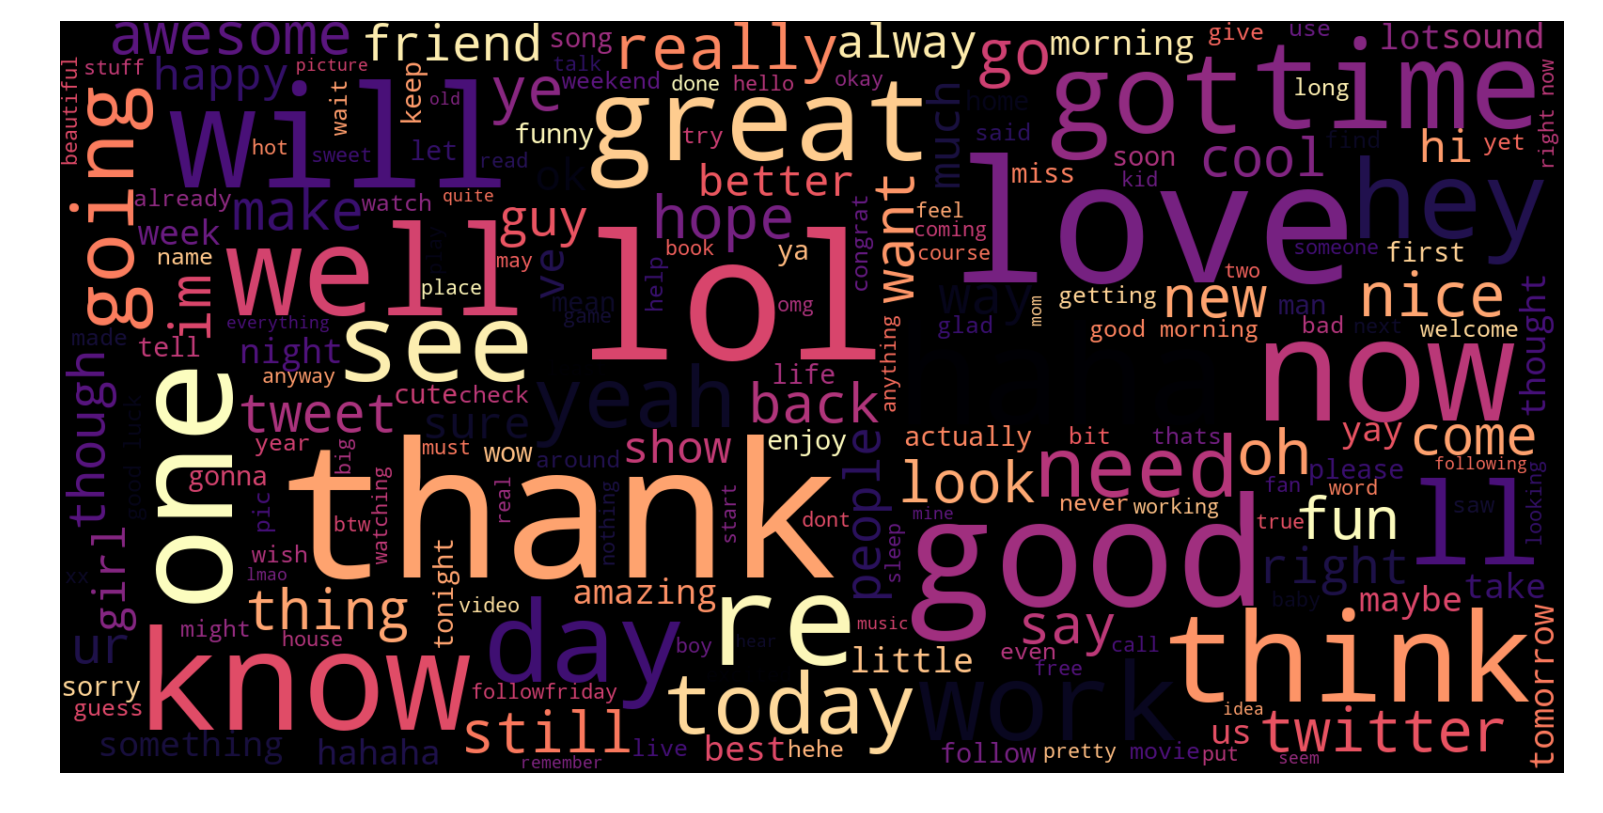

In [32]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### 3 word Cloud for all strings

In [33]:
all_string = []
for t in clean_tweets_data.text:
    all_string.append(t)
all_string = pd.Series(all_string).str.cat(sep=' ')

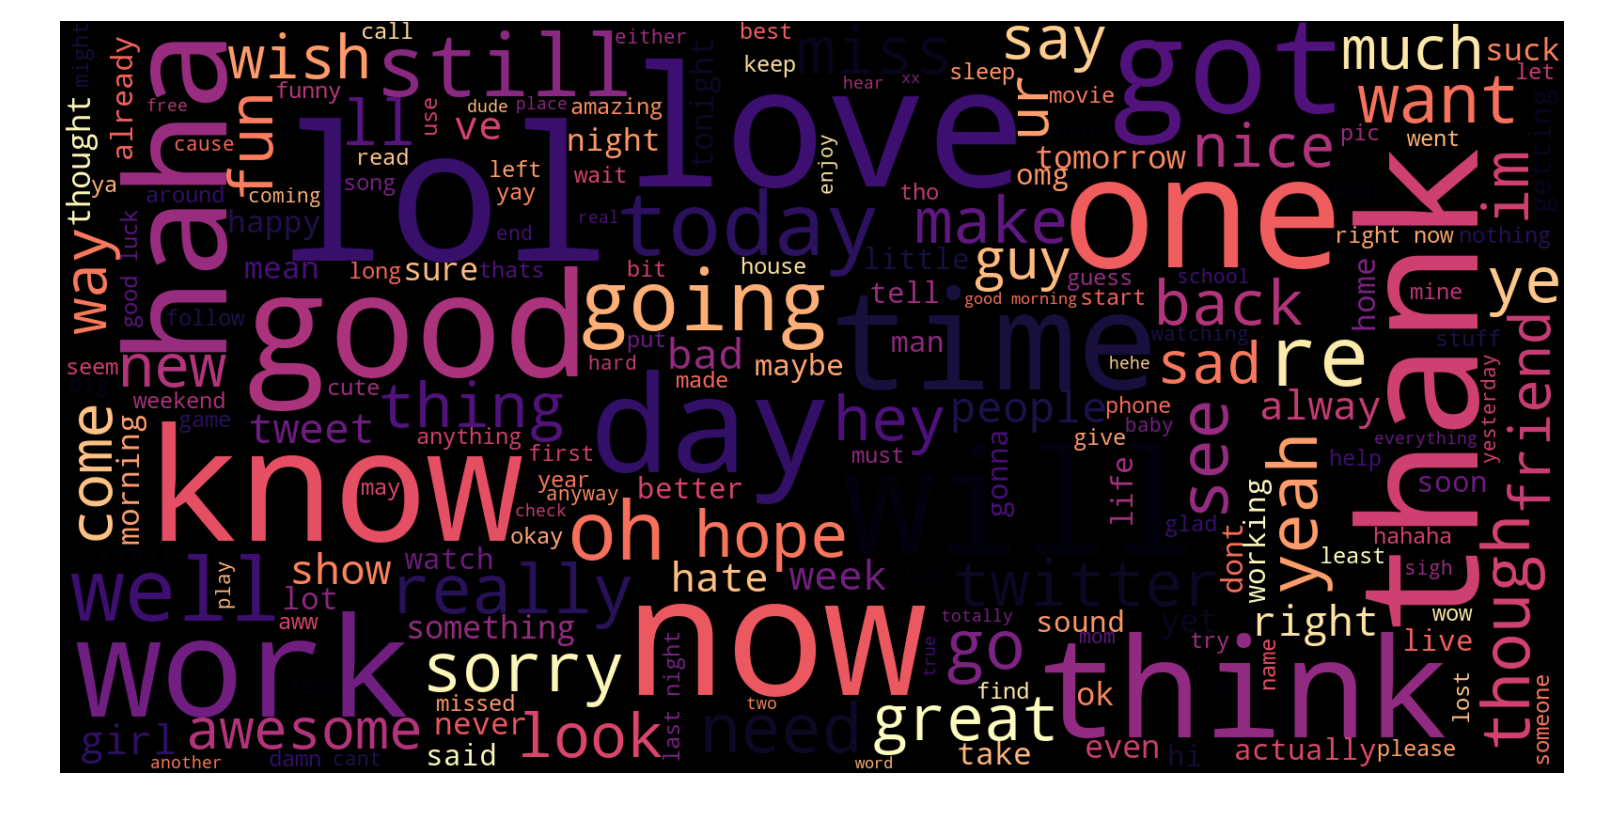

In [34]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(all_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [35]:
del pos_tweets, pos_string, neg_tweets, neg_string, wordcloud, all_string #, df

# Models

## NaiveBayesClassifier with multiple Ngram (unigram and bigram)

In [22]:
stopwords_english = stopwords.words('english')

In [23]:
# clean words, i.e. remove stopwords and punctuation
def clean_words(words, stopwords_english):
    words_clean = []
#     print(type(words))
    for word in words:
        word = word.lower()
        if word not in stopwords_english and word not in string.punctuation:
            words_clean.append(word)    
    return words_clean 

In [24]:
# feature extractor function for unigram
def bag_of_words(words):    
    words_dictionary = dict([word, True] for word in words)    
    return words_dictionary

In [25]:
# feature extractor function for ngrams (bigram)
def bag_of_ngrams(words, n=2):
    words_ng = []
    for item in iter(ngrams(words, n)):
        words_ng.append(item)
    words_dictionary = dict([word, True] for word in words_ng)    
    return words_dictionary

In [26]:
from nltk.tokenize import word_tokenize
text = "It was a very good movie."
words = word_tokenize(text.lower())
words

['it', 'was', 'a', 'very', 'good', 'movie', '.']

In [27]:
bag_of_ngrams(words)

{('it', 'was'): True,
 ('was', 'a'): True,
 ('a', 'very'): True,
 ('very', 'good'): True,
 ('good', 'movie'): True,
 ('movie', '.'): True}

In [28]:
words_clean = clean_words(words, stopwords_english)
words_clean

['good', 'movie']

In [29]:
important_words = ['above', 'below', 'off', 'over', 'under', 'more', 'most', 'such', 'no', 'nor', 'not', 'only', 'so', 'than', 'too', 'very', 'just', 'but']

In [30]:
stopwords_english_for_bigrams = set(stopwords_english) - set(important_words)

In [31]:
words_clean_for_bigrams = clean_words(words, stopwords_english_for_bigrams)
words_clean_for_bigrams

['very', 'good', 'movie']

In [32]:
unigram_features = bag_of_words(words_clean)
unigram_features

{'good': True, 'movie': True}

In [33]:
bigram_features = bag_of_ngrams(words_clean_for_bigrams)
bigram_features

{('very', 'good'): True, ('good', 'movie'): True}

In [34]:
# combine both unigram and bigram features
all_features = unigram_features.copy()
all_features.update(bigram_features)
all_features

{'good': True, 'movie': True, ('very', 'good'): True, ('good', 'movie'): True}

In [35]:
# let's define a new function that extracts all features
# i.e. that extracts both unigram and bigrams features
def bag_of_all_words(words, n=2):
    words_clean = clean_words(words, stopwords_english)
    words_clean_for_bigrams = clean_words(words, stopwords_english_for_bigrams)
 
    unigram_features = bag_of_words(words_clean)
    bigram_features = bag_of_ngrams(words_clean_for_bigrams)
 
    all_features = unigram_features.copy()
    all_features.update(bigram_features)
 
    return all_features

In [36]:
bag_of_all_words(words)

{'good': True, 'movie': True, ('very', 'good'): True, ('good', 'movie'): True}

In [37]:
# import numpy as np
# pos_reviews = np.array([row for row in tweet_data[tweet_data.sentiment == 1].text.str.split()])
pos_reviews = [row for row in clean_tweets_data[clean_tweets_data.sentiment == 1].text.str.split()]
# [value for (index, value) in pos_reviews.items()]
pos_reviews

[['omg', 'its', 'already'],
 ['handed', 'in', 'my', 'uniform', 'today', 'miss', 'you', 'already'],
 ['hmmmm', 'wonder', 'how', 'she', 'my', 'number'],
 ['thanks',
  'to',
  'all',
  'the',
  'haters',
  'up',
  'in',
  'my',
  'face',
  'all',
  'day'],
 ['feeling',
  'strangely',
  'fine',
  'now',
  'gonna',
  'go',
  'listen',
  'to',
  'some',
  'semisonic',
  'to',
  'celebrate'],
 ['you',
  're',
  'the',
  'only',
  'one',
  'who',
  'can',
  'see',
  'this',
  'cause',
  'no',
  'one',
  'else',
  'is',
  'following',
  'me',
  'this',
  'is',
  'for',
  'you',
  'because',
  'you',
  're',
  'pretty',
  'awesome'],
 ['goodbye', 'exams', 'hello', 'alcohol', 'tonight'],
 ['uploading', 'pictures', 'on', 'friendster'],
 ['so',
  'wrote',
  'something',
  'last',
  'week',
  'and',
  'got',
  'call',
  'from',
  'someone',
  'in',
  'the',
  'new',
  'york',
  'office'],
 ['do',
  'need',
  'to',
  'even',
  'say',
  'it',
  'do',
  'well',
  'here',
  'go',
  'anyways',
  'chris',

In [38]:
neg_reviews = [row for row in clean_tweets_data[clean_tweets_data.sentiment == 0].text.str.split()]
neg_reviews

[['is', 'so', 'sad', 'for', 'my', 'apl', 'friend'],
 ['missed', 'the', 'new', 'moon', 'trailer'],
 ['omgaga',
  'im',
  'sooo',
  'im',
  'gunna',
  'cry',
  've',
  'been',
  'at',
  'this',
  'dentist',
  'since',
  'was',
  'suposed',
  'just',
  'get',
  'crown',
  'put',
  'on',
  'mins'],
 ['think', 'mi', 'bf', 'is', 'cheating', 'on', 'me'],
 ['or', 'just', 'worry', 'too', 'much'],
 ['sunny', 'again', 'work', 'tomorrow', 'tv', 'tonight'],
 ['must', 'think', 'about', 'positive'],
 ['this', 'weekend', 'has', 'sucked', 'so', 'far'],
 ['jb', 'isnt', 'showing', 'in', 'australia', 'any', 'more'],
 ['ok', 'thats', 'it', 'you', 'win'],
 ['this', 'is', 'the', 'way', 'feel', 'right', 'now'],
 ['awhhe',
  'man',
  'completely',
  'useless',
  'rt',
  'now',
  'funny',
  'all',
  'can',
  'do',
  'is',
  'twitter'],
 ['huge', 'roll', 'of', 'thunder', 'just', 'now', 'so', 'scary'],
 ['just',
  'cut',
  'my',
  'beard',
  'off',
  'it',
  'only',
  'been',
  'growing',
  'for',
  'well',
  'ov

In [39]:
pos_reviews_set = []
for words in pos_reviews:
#     print(words)
    pos_reviews_set.append((bag_of_all_words(words), 'pos'))
pos_reviews_set

[({'omg': True, 'already': True, ('omg', 'already'): True}, 'pos'),
 ({'handed': True,
   'uniform': True,
   'today': True,
   'miss': True,
   'already': True,
   ('handed', 'uniform'): True,
   ('uniform', 'today'): True,
   ('today', 'miss'): True,
   ('miss', 'already'): True},
  'pos'),
 ({'hmmmm': True,
   'wonder': True,
   'number': True,
   ('hmmmm', 'wonder'): True,
   ('wonder', 'number'): True},
  'pos'),
 ({'thanks': True,
   'haters': True,
   'face': True,
   'day': True,
   ('thanks', 'haters'): True,
   ('haters', 'face'): True,
   ('face', 'day'): True},
  'pos'),
 ({'feeling': True,
   'strangely': True,
   'fine': True,
   'gonna': True,
   'go': True,
   'listen': True,
   'semisonic': True,
   'celebrate': True,
   ('feeling', 'strangely'): True,
   ('strangely', 'fine'): True,
   ('fine', 'gonna'): True,
   ('gonna', 'go'): True,
   ('go', 'listen'): True,
   ('listen', 'semisonic'): True,
   ('semisonic', 'celebrate'): True},
  'pos'),
 ({'one': True,
   'see':

In [40]:
neg_reviews_set = []
for words in neg_reviews:
#     print(words)
    neg_reviews_set.append((bag_of_all_words(words), 'neg'))
neg_reviews_set

[({'sad': True,
   'apl': True,
   'friend': True,
   ('so', 'sad'): True,
   ('sad', 'apl'): True,
   ('apl', 'friend'): True},
  'neg'),
 ({'missed': True,
   'new': True,
   'moon': True,
   'trailer': True,
   ('missed', 'new'): True,
   ('new', 'moon'): True,
   ('moon', 'trailer'): True},
  'neg'),
 ({'omgaga': True,
   'im': True,
   'sooo': True,
   'gunna': True,
   'cry': True,
   'dentist': True,
   'since': True,
   'suposed': True,
   'get': True,
   'crown': True,
   'put': True,
   'mins': True,
   ('omgaga', 'im'): True,
   ('im', 'sooo'): True,
   ('sooo', 'im'): True,
   ('im', 'gunna'): True,
   ('gunna', 'cry'): True,
   ('cry', 'dentist'): True,
   ('dentist', 'since'): True,
   ('since', 'suposed'): True,
   ('suposed', 'just'): True,
   ('just', 'get'): True,
   ('get', 'crown'): True,
   ('crown', 'put'): True,
   ('put', 'mins'): True},
  'neg'),
 ({'think': True,
   'mi': True,
   'bf': True,
   'cheating': True,
   ('think', 'mi'): True,
   ('mi', 'bf'): True

In [41]:
print (len(pos_reviews_set), len(neg_reviews_set)) # Output: (1000, 1000)
 
# radomize pos_reviews_set and neg_reviews_set
# doing so will output different accuracy result everytime we run the program
from random import shuffle 
shuffle(pos_reviews_set)
shuffle(neg_reviews_set)

test_set = pos_reviews_set[:int((0.2*len(pos_reviews_set)))] + neg_reviews_set[:int((0.2*len(neg_reviews_set)))]
train_set = pos_reviews_set[int((0.2*len(pos_reviews_set))):] + neg_reviews_set[int((0.2*len(neg_reviews_set))):]
 
print(len(test_set),  len(train_set))

56204 43319
19903 79620


In [42]:
%%time
from nltk import classify
from nltk import NaiveBayesClassifier
 
classifier = NaiveBayesClassifier.train(train_set)
 
accuracy = classify.accuracy(classifier, test_set)
print(accuracy)
 
print (classifier.show_most_informative_features(10)) 

0.7312967894287293
Most Informative Features
    ('get', 'followers') = True              pos : neg    =     77.3 : 1.0
    ('followers', 'day') = True              pos : neg    =     72.7 : 1.0
           ('so', 'sad') = True              neg : pos    =     54.2 : 1.0
        ('good', 'home') = True              neg : pos    =     46.3 : 1.0
        ('makes', 'sad') = True              neg : pos    =     34.0 : 1.0
         ('very', 'sad') = True              neg : pos    =     32.4 : 1.0
    ('thanks', 'follow') = True              pos : neg    =     28.8 : 1.0
         ('wont', 'let') = True              neg : pos    =     28.1 : 1.0
         ('no', 'money') = True              neg : pos    =     27.2 : 1.0
        ('wanted', 'go') = True              neg : pos    =     27.2 : 1.0
None
CPU times: user 23.9 s, sys: 1.9 s, total: 25.8 s
Wall time: 26.1 s


In [43]:
train_set

[({'tastatur': True,
   'also': True,
   'means': True,
   'keyboard': True,
   'norwegan': True,
   ('tastatur', 'also'): True,
   ('also', 'means'): True,
   ('means', 'keyboard'): True,
   ('keyboard', 'norwegan'): True},
  'pos'),
 ({'june': True,
   'portugal': True,
   'know': True,
   'go': True,
   'another': True,
   'catching': True,
   'song': True,
   ('june', 'portugal'): True,
   ('portugal', 'not'): True,
   ('not', 'know'): True,
   ('know', 'go'): True,
   ('go', 'just'): True,
   ('just', 'another'): True,
   ('another', 'catching'): True,
   ('catching', 'song'): True},
  'pos'),
 ({'shouuuuuld': True,
   'hangout': True,
   'go': True,
   ('shouuuuuld', 'hangout'): True,
   ('hangout', 'go'): True},
  'pos'),
 ({'really': True,
   'convinced': True,
   ('really', 'convinced'): True,
   ('convinced', 'not'): True},
  'pos'),
 ({'hey': True,
   'liked': True,
   'movie': True,
   'kinda': True,
   'nightmare': True,
   'christmas': True,
   'meets': True,
   'smthg': 

In [44]:
from nltk.tokenize import word_tokenize

def test(text):
    custom_review_tokens = word_tokenize(text)
    custom_review_set = bag_of_all_words(custom_review_tokens)
    print (classifier.classify(custom_review_set))

    # probability result
    prob_result = classifier.prob_classify(custom_review_set)
    print (prob_result)
    print (prob_result.max())
    print (prob_result.prob("neg"))
    print (prob_result.prob("pos"))

In [45]:
custom_review = "I hated the film. It was a disaster. Poor direction, bad acting."
test(custom_review)

neg
<ProbDist with 2 samples>
neg
0.9933019810599495
0.006698018940047511


In [46]:
custom_review = "It was a wonderful and amazing movie. I loved it. Best direction, good acting."
test(custom_review)

pos
<ProbDist with 2 samples>
pos
0.055061130476813165
0.9449388695231894


In [47]:
custom_review = 'handed in my uniform today miss you already'
test(custom_review)

neg
<ProbDist with 2 samples>
neg
0.9997441858960099
0.00025581410398968355


In [1]:
custom_review = input('please enter a sentence :')
test(custom_review)

please enter a sentence :this is a good idea.


NameError: name 'test' is not defined

## splitting the tweets data into train and test sets

In [53]:
X_train, X_test, y_train, y_test = train_test_split(clean_tweets_data['text'], clean_tweets_data['sentiment'], test_size = 0.3, random_state = 37)
print ("X_train: ", len(X_train))
print("X_test: ", len(X_test))
print("y_train: ", len(y_train))
print("y_test: ", len(y_test))

X_train:  69666
X_test:  29857
y_train:  69666
y_test:  29857


In [54]:
# corpus = []
# for i in range(0,(len(clean_tweets_data))):
#     review = re.sub('[^a-zA-Z]', ' ', clean_tweets_data['text'][i])
#     review = review.lower()
#     review = review.split()
#     print(review)
#     ps = PorterStemmer()
#     review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
#     review = ' '.join(review)
#     corpus.append(review)

### Countvectorizer

In [55]:
cv = CountVectorizer(max_features = 1500)
cv.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=1500, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [56]:
X_train_cv = cv.transform(X_train)
X_train_cv

<69666x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 626939 stored elements in Compressed Sparse Row format>

In [57]:
X_test_cv = cv.transform(X_test)
X_test_cv

<29857x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 267718 stored elements in Compressed Sparse Row format>

## MultiNominal Naive Bayes

In [59]:
%%time
mnb = MultinomialNB(alpha = 0.5)
MNB_model = mnb.fit(X_train_cv,y_train)

y_mnb = mnb.predict(X_test_cv)

CPU times: user 27.4 ms, sys: 17.4 ms, total: 44.8 ms
Wall time: 45.1 ms


In [60]:
print('Naive Bayes Accuracy: ', accuracy_score(y_mnb , y_test))
print('Naive Bayes confusion_matrix: ', confusion_matrix(y_mnb, y_test))
MNB_accuracy_train  = round(MNB_model.score(X_test_cv,y_test) * 100, 2)
MNB_accuracy_train 

Naive Bayes Accuracy:  0.7515155574907056
Naive Bayes confusion_matrix:  [[ 9071  3486]
 [ 3933 13367]]


75.15

In [61]:
# coefficeints of the trained model
print('Coefficient of model :', MNB_model.coef_)
print('-'*45)
# intercept of the model
print('Intercept of model',MNB_model.intercept_)

Coefficient of model : [[-8.24440355 -5.69009259 -8.39240037 ... -8.93227368 -8.62633816
  -8.24440355]]
---------------------------------------------
Intercept of model [-0.57119101]


## SVM (Support Vector Machine)

In [62]:
%%time
svc = SVC(kernel='sigmoid', gamma=1.0)
SVC_model = svc.fit(X_train_cv,y_train)

y_svc = svc.predict(X_test_cv)

CPU times: user 11min 50s, sys: 16 s, total: 12min 6s
Wall time: 12min 40s


In [63]:
print('SVM Accuracy: ', accuracy_score(y_svc , y_test))
print('SVM confusion_matrix: ', confusion_matrix(y_svc, y_test))
SVC_accuracy_train  = round(SVC_model.score(X_test_cv,y_test) * 100, 2)
SVC_accuracy_train 

SVM Accuracy:  0.556519409183776
SVM confusion_matrix:  [[ 6429  6666]
 [ 6575 10187]]


55.65

## KNN Classification

In [64]:
%%time
knc = KNeighborsClassifier(n_neighbors=100)
KNNC_model = knc.fit(X_train_cv,y_train)

y_knc = knc.predict(X_test_cv)

CPU times: user 1min 26s, sys: 51.2 s, total: 2min 17s
Wall time: 2min 30s


In [65]:
print('KNeighbors Accuracy_score: ',accuracy_score(y_test,y_knc))
print('KNeighbors confusion_matrix: ', confusion_matrix(y_test, y_knc))
KNNC_accuracy_train  = round(KNNC_model.score(X_test_cv,y_test) * 100, 2)
KNNC_accuracy_train 

KNeighbors Accuracy_score:  0.6591419097699032
KNeighbors confusion_matrix:  [[ 4554  8450]
 [ 1727 15126]]


65.91

## Decision Tree

In [66]:
%%time
dtc = DecisionTreeClassifier()
DTC_model = dtc.fit(X_train_cv,y_train)

y_dtc = dtc.predict(X_test_cv)

CPU times: user 21 s, sys: 185 ms, total: 21.2 s
Wall time: 21.4 s


In [67]:
print('Decision Tree Accuracy: ',accuracy_score(y_test,y_dtc))
print('Decision Tree confusion_matrix: ', confusion_matrix(y_dtc, y_test)) 
DTC_accuracy_train  = round(DTC_model.score(X_test_cv,y_test) * 100, 2)
DTC_accuracy_train 

Decision Tree Accuracy:  0.6778309944066718
Decision Tree confusion_matrix:  [[ 8337  4952]
 [ 4667 11901]]


67.78

## Extra Tree Classification

In [68]:
%%time
etc = ExtraTreesClassifier(n_estimators=37, random_state=252)
ETC_model = etc.fit(X_train_cv,y_train)

y_etc = etc.predict(X_test_cv)

CPU times: user 1min 17s, sys: 950 ms, total: 1min 18s
Wall time: 1min 21s


In [69]:
print('Extra Tree Accuracy_score: ',accuracy_score(y_test,y_etc))
print('Extra Tree confusion_matrix: ', confusion_matrix(y_etc, y_test))
ETC_accuracy_train  = round(ETC_model.score(X_test_cv,y_test) * 100, 2)
ETC_accuracy_train 

Extra Tree Accuracy_score:  0.7459892152594032
Extra Tree confusion_matrix:  [[ 9205  3785]
 [ 3799 13068]]


74.6

## Random Forest Classification¶

In [70]:
%%time
rfc = RandomForestClassifier(n_estimators=37, random_state=252)
RFC_model = rfc.fit(X_train_cv,y_train)

y_rfc = rfc.predict(X_test_cv)

CPU times: user 58.3 s, sys: 665 ms, total: 58.9 s
Wall time: 1min 1s


In [71]:
print('Random Forest Accuracy_score: ',accuracy_score(y_test,y_rfc))
print('Random Forest confusion_matrix: ', confusion_matrix(y_rfc, y_test)) 
RFC_accuracy_train  = round(RFC_model.score(X_test_cv,y_test) * 100, 2)
RFC_accuracy_train 

Random Forest Accuracy_score:  0.7416351274408012
Random Forest confusion_matrix:  [[ 9120  3830]
 [ 3884 13023]]


74.16

## Adaptive Boosting Classification

In [72]:
%%time
abc = AdaBoostClassifier(n_estimators=37, random_state=252)
ABC_model = abc.fit(X_train_cv,y_train)

y_abc = abc.predict(X_test_cv)

CPU times: user 4.46 s, sys: 311 ms, total: 4.77 s
Wall time: 2.48 s


In [73]:
print('AdaBoost Accuracy_score: ',accuracy_score(y_test,y_abc))
print('AdaBoost confusion_matrix: ', confusion_matrix(y_abc, y_test))
ABC_accuracy_train  = round(ABC_model.score(X_test_cv,y_test) * 100, 2)
ABC_accuracy_train 

AdaBoost Accuracy_score:  0.6975248685400408
AdaBoost confusion_matrix:  [[ 6438  2465]
 [ 6566 14388]]


69.75

## Bagging Classification

In [74]:
%%time
bc = BaggingClassifier(n_estimators=9, random_state=252)
BC_model = bc.fit(X_train_cv,y_train)

y_bc = bc.predict(X_test_cv)

CPU times: user 2min 33s, sys: 1.22 s, total: 2min 34s
Wall time: 2min 39s


In [75]:
print('Bagging Accuracy_score: ',accuracy_score(y_test,y_bc))
print('Bagging confusion_matrix: ', confusion_matrix(y_bc, y_test))
BC_accuracy_train  = round(BC_model.score(X_test_cv,y_test) * 100, 2)
BC_accuracy_train 

Bagging Accuracy_score:  0.7069698898080852
Bagging confusion_matrix:  [[ 8697  4442]
 [ 4307 12411]]


70.7

## Logistic Reg

In [76]:
%%time
log_model = LogisticRegression()
LRC_model = log_model.fit(X_train_cv,y_train)

y_lr = log_model.predict(X_test_cv)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 1.02 s, sys: 35.1 ms, total: 1.06 s
Wall time: 967 ms


In [77]:
print('LR Accuracy_score: ',accuracy_score(y_test,y_bc))
print('LR confusion_matrix: ', confusion_matrix(y_bc, y_test)) 
LRC_accuracy_train  = round(LRC_model.score(X_test_cv,y_test) * 100, 2)
LRC_accuracy_train

LR Accuracy_score:  0.7069698898080852
LR confusion_matrix:  [[ 8697  4442]
 [ 4307 12411]]


75.74

In [78]:
# coefficeints of the trained model
print('Coefficient of model :', log_model.coef_)
print('-'*45)
# intercept of the model
print('Intercept of model',log_model.intercept_)

Coefficient of model : [[-0.54409023 -0.10513203  0.3994293  ...  0.42570148  0.8695954
   0.47827423]]
---------------------------------------------
Intercept of model [0.49351251]


## Gradian Boosting Tunning (GBM)

In [79]:
%%time
gbm_model = GradientBoostingClassifier()
GBM_model = gbm_model.fit(X_train_cv,y_train)

y_gbm = gbm_model.predict(X_test_cv)

CPU times: user 18.4 s, sys: 730 ms, total: 19.2 s
Wall time: 10 s


In [85]:
print('GBM Accuracy_score: ',accuracy_score(y_test,y_gbm))
print('GBM confusion_matrix: ', confusion_matrix(y_gbm, y_test))
GBM_accuracy_train  = round(GBM_model.score(X_test_cv,y_test) * 100, 2)
GBM_accuracy_train

GBM Accuracy_score:  0.6997354054325619
GBM confusion_matrix:  [[ 6208  2169]
 [ 6796 14684]]


69.97

#### boosting

# Consult

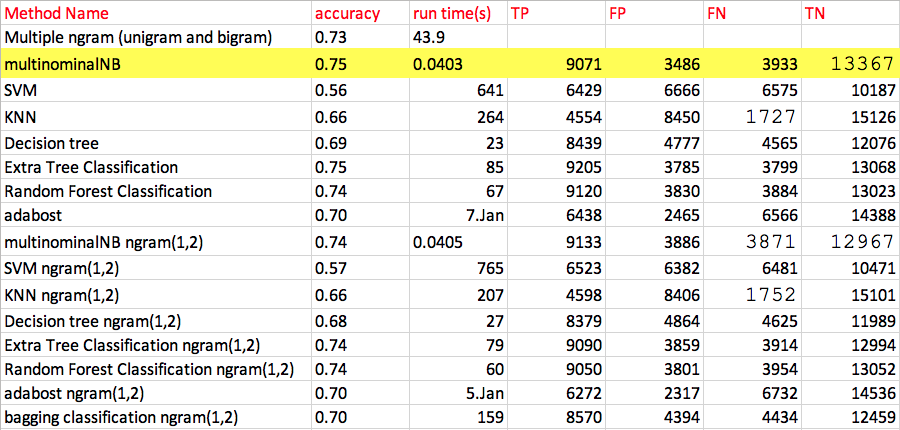

We compared many methods and conlust is very open. If we compare specially run time and accuracy Multinominal Naive Bayes is best one. There is a one important thing: it is a best not better.